In [1]:
import sympy as sym
import numpy as np
from scipy import linalg
from scipy import signal

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

# Derive equations of motion

The `sympy.physics.mechanics` module makes it easier to work with (and display) time derivatives.

In [2]:
from sympy.physics import mechanics
mechanics.init_vprinting()

Define parameters in symbolic form.

In [3]:
# Principal moments of inertia
J_1x, J_1y, J_1z = sym.symbols('J_1x, J_1y, J_1z')
J_2x, J_2y, J_2z = sym.symbols('J_2x, J_2y, J_2z')
J_3x, J_3y, J_3z = sym.symbols('J_3x, J_3y, J_3z')

# Moment of inertia matrices in body-fixed reference frames
J1 = sym.Matrix.diag(J_1x, J_1y, J_1z)
J2 = sym.Matrix.diag(J_2x, J_2y, J_2z)
J3 = sym.Matrix.diag(J_3x, J_3y, J_3z)

# Spar length
r = sym.symbols('r')

# Load mass
m = sym.symbols('m')

# Acceleration of gravity
g = sym.symbols('g')

Define variables.

In [4]:
# Time
t = sym.Symbol('t')

# Joint angles:
q1, q2, q3 = mechanics.dynamicsymbols('q1, q2, q3')

# Joint velocities
v1 = q1.diff(t)
v2 = q2.diff(t)
v3 = q3.diff(t)

# Joint accelerations
a1 = v1.diff(t)
a2 = v2.diff(t)
a3 = v3.diff(t)

# Torques:
tau2, tau3 = sym.symbols('tau2, tau3')

Compute angular velocity of each link with respect to body-fixed reference frames (the choice of frame is very important - using a space-fixed reference frame is a common mistake).

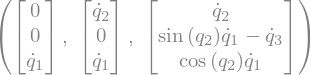

In [5]:
c1 = sym.cos(q1)
s1 = sym.sin(q1)
R_p_in_w = sym.Matrix([[c1, -s1, 0], [s1, c1, 0], [0, 0, 1]])

c2 = sym.cos(q2)
s2 = sym.sin(q2)
R_g_in_p = sym.Matrix([[1, 0, 0], [0, c2, -s2], [0, s2, c2]])

w1 = sym.Matrix([[0], [0], [v1]])
w2 = R_p_in_w.T * w1 + sym.Matrix([[v2], [0], [0]])
w3 = R_g_in_p.T * w2 + sym.Matrix([[0], [-v3], [0]])

# Show result
w1, w2, w3

Compute position and velocity of load mass.

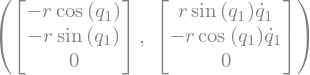

In [6]:
p = R_p_in_w * sym.Matrix([-r, 0, 0])
v = p.diff(t)

# Show result
p, v

Compute Lagrangian.

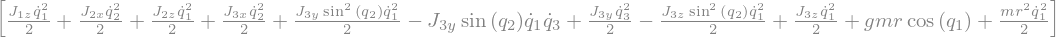

In [7]:
T = ((w1.T * J1 * w1) + (w2.T * J2 * w2) + (w3.T * J3 * w3) + (v.T * m * v)) / 2
V = m * g * (sym.Matrix([1, 0, 0]).T * p)
L = sym.simplify(T - V)

# Show result
L

Compute equations of motion.

In [8]:
EOM = L.jacobian([v1, v2, v3]).diff(t) - L.jacobian([q1, q2, q3]) - sym.Matrix([0, tau2, tau3]).T

Simplify equations of motion by solving for accelerations.

In [9]:
sol = sym.solve(EOM, [a1, a2, a3])
h = sym.together(sym.simplify(sym.Matrix([sol[a1], sol[a2], sol[a3]]), full=True))

Assume $\tau_3=0$ and look only at the equations of motion that govern the platform and the gimbal:

In [10]:
h = h[0:2, 0].subs(tau3, 0)

Display the vector-valued function $h$ for which the equations of motion can be written as

$$\begin{bmatrix} \ddot{q}_1 \\ \ddot{q}_2 \end{bmatrix} = h(q_1, q_2, \dot{q}_1, \dot{q}_2, \tau_2)$$

where everything else (mass and inertial parameters, spar length, acceleration of gravity, and rotor velocity $\dot{q}_3$) is assumed constant.

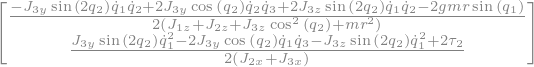

In [11]:
h

Put EOMs in standard form.

In [12]:
# Standard form
f_symparams = sym.Matrix.vstack(sym.Matrix([v1, v2]), h)

# Standard form without dynamic symbols
qq1, qq2, vv1, vv2, v_rotor = sym.symbols('qq1, qq2, vv1, vv2, v_rotor')
f_symparams = mechanics.msubs(f_symparams, {
    q1: qq1,
    q2: qq2,
    v1: vv1,
    v2: vv2,
    v3: v_rotor,
})
q1, q2, v1, v2 = sym.symbols('q1, q2, v1, v2')
f_symparams = f_symparams.subs([
    (qq1, q1),
    (qq2, q2),
    (vv1, v1),
    (vv2, v2),
])

Plug in constants and convert floating-point to rational numbers.

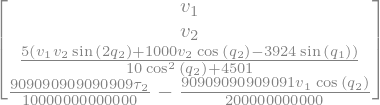

In [13]:
f = sym.simplify(sym.nsimplify(f_symparams.subs([
    (J_1z, 0.5),
    (J_2x, 0.001),
    (J_2z, 0.001),
    (J_3x, 0.01),
    (J_3y, 0.01),
    (J_3z, 0.01),
    (m, 1.),
    (r, 2.),
    (g, 9.81),
    (v_rotor, 500.),
]), rational=True))

display(f)

# Derive a state-space model

Choose an equilibrium point.

In [27]:
q1e = np.pi
q2e = np.pi / 2
v1e = 0.
v2e = 0.
tau2e = 0.

# Verify that this is actually an equilibrium point
f_num = sym.lambdify([q1, q2, v1, v2, tau2], f)
if np.allclose(f_num(q1e, q2e, v1e, v2e, tau2e), 0.):
    print('Valid equilibrium point.')
else:
    print('INVALID EQUILIBRIUM POINT!')

Valid equilibrium point.


Find $A$ and $B$.

In [28]:
# Find A and B in symbolic form
A_sym = f.jacobian([q1, q2, v1, v2])
B_sym = f.jacobian([tau2])

# Create lambda functions to allow numerical evaluation of A and B
A_num = sym.lambdify([q1, q2, v1, v2, tau2], A_sym)
B_num = sym.lambdify([q1, q2, v1, v2, tau2], B_sym)

# Find A and B in numeric form (making sure the result is floating-point)
A = A_num(q1e, q2e, v1e, v2e, tau2e).astype(float)
B = B_num(q1e, q2e, v1e, v2e, tau2e).astype(float)

# Show result
print(f'A =\n{A}\n\nB =\n{B}')

A =
[[ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]
 [ 4.35903133 -0.          0.          0.        ]
 [ 0.          0.         -0.          0.        ]]

B =
[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [90.90909091]]


# Check if the state-space model is controllable

Find controllability matrix.

In [29]:
W = np.block([B, A @ B, A @ A @ B, A @ A @ A @ B])
print(W)

[[ 0.          0.          0.         -0.        ]
 [ 0.         90.90909091  0.         -0.        ]
 [ 0.          0.         -0.          0.        ]
 [90.90909091  0.         -0.          0.        ]]


Find determinant of controllability matrix.

In [30]:
np.linalg.det(W)

Find rank of controllability matrix.

In [31]:
np.linalg.matrix_rank(W)

2

Find condition number of controllability matrix (i.e., the ratio of the largest singular value to the smallest singular value).

# Do control design by eigenvalue placement

Choose desired eigenvalue locations.

In [32]:
p = [-2., -3., -4., -5.]

Find gain matrix by eigenvalue placement.

In [33]:
K = signal.place_poles(A, B, p).gain_matrix
print(f'K = \n{K}')

K = 
[[-8.04002667e+13  1.07155071e-01 -9.00340649e+13  7.07887678e-02]]


In [ ]:
K

Check that eigenvalues are in the right location.

In [34]:
print(linalg.eigvals(A - B @ K))

[ 2.11813416+0.j         -2.1227293 +0.38407448j -2.1227293 -0.38407448j
 -4.30801809+0.j        ]


# If a system is not controllable, are we completely out of luck?

Find the eigenvalues produced by a particular choice of gain matrix.

In [ ]:
# Gain matrix
K = np.array([[5., 5., 1., 1.]])

# Eigenvalues
print(linalg.eigvals(A - B @ K))

Find the eigenvalues produced by a different choice of gain matrix.

In [ ]:
# Gain matrix
K = np.array([[1., 10., 2., 3.]])

# Eigenvalues
print(linalg.eigvals(A - B @ K))